In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from scipy.stats import linregress
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import rankdata

import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
PROTEINS = [
    "5P",
    "NSP1",
    "NSP2",
    "NSP3",
    "NSP4",
    "NSP5",
    "NSP6",
    "NSP7",
    "NSP8",
    "NSP9",
    "NSP10",
    "NSP11",
    "NSP12",
    "NSP13",
    "NSP14",
    "NSP15",
    "NSP16",
    "Spike",
    "NS3",
    "E",
    "M",
    "NS6",
    "NS7a",
    "NS7b",
    "NS8",
    "N",
    "NS9b",
    "NS9c",
    "3P",
    "RNA"
]

ANNOTATION = {
    "5P": "1-265",
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    "NSP6": "10973-11842",
    "NSP7": "11843-12091",
    "NSP8": "12092-12685",
    "NSP9": "12686-13024",
    "NSP10": "13025-13441",
    "NSP11": "13442-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    "NS6": "27202-27387",
    "NS7a": "27394-27759",
    "NS7b": "27756-27887",
    "NS8": "27894-28259",
    "N": "28274-29533",
    "NS9b": "28284-28577",
    "NS9c": "28734-28955",
    "3P": "29534-29903"
}

In [3]:
def read_fasta(path):
    result = ""
    description = ""

    ff = open(path, "r")

    line = next(ff, None)
    while line:
        line = line.rstrip("\n")
        if not line:
            line = next(ff, None)
            continue

        if line.startswith(">"):
            if result:
                yield description, result
            description = line.lstrip(">")
            result = ""
        else:
            result += line

        line = next(ff, None)

    yield description, result
    ff.close()
    
def percent(seq, chr="N"):
    count = 0
    for char in seq:
        if char == chr:
            count += 1
    return count / len(seq)

def region_count(reg, start=None, end=None):
    reg = reg.lstrip("[").rstrip("]").split(", ")
    if not (start is None) and not (end is None):
        reg = [s for s in reg if s and (start <= int(s) <= end)]
    else:
        reg = [s for s in reg if s]
    return len(reg)

# SARS-CoV-2 variants distributed in Berlin

In [4]:
# meta preparation

In [5]:
meta_df = pd.read_csv(
    "../../gisaid/germany_ber_meta.csv",
    sep=",", index_col=0)

rna_df = pd.DataFrame(columns=["strain", "length", "polyA", "percN"])
tqdrator = tqdm.tqdm(read_fasta("../../gisaid/germany_ber.fasta"), total=24778)
for covid, rna in tqdrator:
    length = len(rna)
    perc = percent(rna, "N")
    poly = len(rna) - len(rna.rstrip("A"))
    append_df = pd.DataFrame(
        columns=rna_df.columns.to_list(),
        data=[[
            covid,
            length,
            poly,
            perc
        ]]
    )
    rna_df = pd.concat([rna_df, append_df], ignore_index=True)

rna_df.index = rna_df["strain"]
rna_df = rna_df.drop(columns=["strain"])
meta_df = meta_df.join(rna_df, how="inner")

meta_df["date"] = meta_df.index.str.split("|").str[1]
meta_df["date"] = pd.to_datetime(meta_df["date"], format="%Y-%m-%d")
meta_df = meta_df.sort_values(by=["date"])

meta_df["date"] = meta_df.index.str.split("|").str[1]
meta_df["date"] = pd.to_datetime(meta_df["date"], format="%Y-%m-%d")
meta_df = meta_df.sort_values(by=["date"])

meta_df = meta_df.loc[meta_df["date"].astype("str").apply(lambda dt: len(dt.split("-"))) == 3]
meta_df["year"] = meta_df["date"].astype("str").str.split("-").str[0].astype("int")
meta_df["month"] = meta_df["date"].astype("str").str.split("-").str[1].astype("int")
meta_df["day"] = meta_df["date"].astype("str").str.split("-").str[2].astype("int")
meta_df["days"] = meta_df["day"] + meta_df["month"] * 30 + meta_df["year"] * 365
start = int(meta_df.iloc[0]["days"])
meta_df["days"] -= start
meta_df = meta_df.drop(columns=["year", "month", "day"])

28420it [02:15, 209.17it/s]                           


In [6]:
# Meta description

In [7]:
print(len(meta_df))

28420


In [8]:
print(len(
    meta_df.loc[
        meta_df["percN"] == 0.
    ]
))
print(len(
    meta_df.loc[
        meta_df["percN"] < 0.001
    ]
))

4215
12365


<AxesSubplot:xlabel='days', ylabel='Count'>

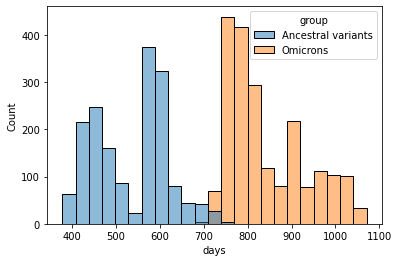

In [9]:
plot_df = meta_df.copy()
plot_df = plot_df.loc[
    (~plot_df["scorpio_call"].isna()) & \
    (plot_df["percN"] == 0.)
]

plot_df["group"] = "Ancestral variants"
plot_df.loc[
    plot_df["scorpio_call"].str.contains("Omicron"),
    "group"
] = "Omicrons"

sns.histplot(
    x="days",
    hue="group",
    data=plot_df[["days", "group"]]
)

MannwhitneyuResult(statistic=1418291.0, pvalue=2.0623116390458293e-23)


<AxesSubplot:xlabel='length', ylabel='Count'>

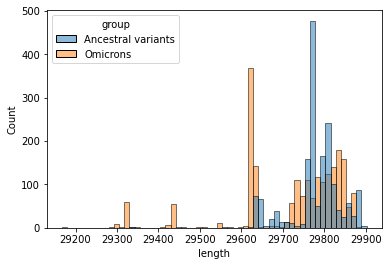

In [10]:
print(mannwhitneyu(
    plot_df.loc[
        plot_df["group"] == "Omicrons",
        "length"].to_list(),
    plot_df.loc[
        plot_df["group"] == "Ancestral variants",
        "length"].to_list(),
    alternative="less"
))

sns.histplot(
    x="length",
    hue="group",
    data=plot_df
)

In [11]:
# Berlin VOC's description

In [12]:
df = meta_df.loc[
    (~meta_df["scorpio_call"].isna()) & \
    (meta_df["percN"] == 0.) & \
    (meta_df["length"] > 29000)
]

STRAINS = []
df["strain"] = df.index
STRAINS = df["strain"].to_list()
START = meta_df.iloc[0]["date"]

<ipython-input-12-a04314270676>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["strain"] = df.index


In [13]:
print(START)
STRAINS[:1]

2020-01-01 00:00:00


['hCoV-19/Germany/BE-ChVir22347/2021|2021-01-14|2021-11-05']

In [14]:
print(meta_df.iloc[0]["date"])
print(meta_df.iloc[-1]["date"])
print(len(meta_df))

2020-01-01 00:00:00
2022-12-20 00:00:00
28420


In [15]:
print(meta_df.loc[STRAINS].iloc[0]["date"])
print(meta_df.loc[STRAINS].iloc[-1]["date"])

2021-01-14 00:00:00
2022-12-12 00:00:00


In [16]:
print(meta_df.iloc[0]["date"])
print(meta_df.iloc[-1]["date"])

2020-01-01 00:00:00
2022-12-20 00:00:00


In [17]:
for i, row in meta_df[["scorpio_call"]].value_counts().to_frame("Initial").join(
    meta_df.loc[STRAINS][["scorpio_call"]].value_counts().to_frame("Selected"),
    how="outer"
).fillna(0).iterrows():
    print(i[0], "&", row["Initial"], "&", row["Selected"], "\\\\")

Alpha (B.1.1.7-like) & 3791.0 & 759.0 \\
B.1.1.318-like & 10.0 & 0.0 \\
B.1.1.7-like+E484K & 87.0 & 17.0 \\
B.1.617.1-like & 16.0 & 2.0 \\
Beta (B.1.351-like) & 102.0 & 4.0 \\
Delta (AY.4-like) & 736.0 & 49.0 \\
Delta (AY.4.2-like) & 73.0 & 12.0 \\
Delta (B.1.617.2-like) & 8625.0 & 841.0 \\
Delta (B.1.617.2-like) +K417N & 7.0 & 2.0 \\
Eta (B.1.525-like) & 155.0 & 2.0 \\
Gamma (P.1-like) & 24.0 & 1.0 \\
Lambda (C.37-like) & 8.0 & 2.0 \\
Mu (B.1.621-like) & 3.0 & 0.0 \\
Omicron (BA.1-like) & 2251.0 & 539.0 \\
Omicron (BA.2-like) & 5736.0 & 887.0 \\
Omicron (BA.4-like) & 204.0 & 28.0 \\
Omicron (BA.5-like) & 4285.0 & 591.0 \\
Omicron (Unassigned) & 767.0 & 9.0 \\
Probable Omicron (BA.1-like) & 86.0 & 2.0 \\
Probable Omicron (BA.2-like) & 19.0 & 3.0 \\
Probable Omicron (BA.4-like) & 1.0 & 0.0 \\
Probable Omicron (BA.5-like) & 13.0 & 5.0 \\
Probable Omicron (Unassigned) & 32.0 & 0.0 \\


In [18]:
for i, row in pd.DataFrame(meta_df[["scorpio_call"]].value_counts()).sort_values(by="scorpio_call").iterrows():
    print(i[0], "&", row[0], "\\\\")

Alpha (B.1.1.7-like) & 3791 \\
B.1.1.318-like & 10 \\
B.1.1.7-like+E484K & 87 \\
B.1.617.1-like & 16 \\
Beta (B.1.351-like) & 102 \\
Delta (AY.4-like) & 736 \\
Delta (AY.4.2-like) & 73 \\
Delta (B.1.617.2-like) & 8625 \\
Delta (B.1.617.2-like) +K417N & 7 \\
Eta (B.1.525-like) & 155 \\
Gamma (P.1-like) & 24 \\
Lambda (C.37-like) & 8 \\
Mu (B.1.621-like) & 3 \\
Omicron (BA.1-like) & 2251 \\
Omicron (BA.2-like) & 5736 \\
Omicron (BA.4-like) & 204 \\
Omicron (BA.5-like) & 4285 \\
Omicron (Unassigned) & 767 \\
Probable Omicron (BA.1-like) & 86 \\
Probable Omicron (BA.2-like) & 19 \\
Probable Omicron (BA.4-like) & 1 \\
Probable Omicron (BA.5-like) & 13 \\
Probable Omicron (Unassigned) & 32 \\


In [19]:
meta_df = meta_df.loc[STRAINS]

In [20]:
print(meta_df["scorpio_call"].value_counts().sum())
meta_df["scorpio_call"].value_counts()

3755


Omicron (BA.2-like)              887
Delta (B.1.617.2-like)           841
Alpha (B.1.1.7-like)             759
Omicron (BA.5-like)              591
Omicron (BA.1-like)              539
Delta (AY.4-like)                 49
Omicron (BA.4-like)               28
B.1.1.7-like+E484K                17
Delta (AY.4.2-like)               12
Omicron (Unassigned)               9
Probable Omicron (BA.5-like)       5
Beta (B.1.351-like)                4
Probable Omicron (BA.2-like)       3
Delta (B.1.617.2-like) +K417N      2
B.1.617.1-like                     2
Probable Omicron (BA.1-like)       2
Eta (B.1.525-like)                 2
Lambda (C.37-like)                 2
Gamma (P.1-like)                   1
Name: scorpio_call, dtype: int64

In [21]:
meta_df.loc[:, "group"] = "first"
meta_df.loc[meta_df["scorpio_call"].str.contains("micron"), "group"] = "second"

In [22]:
print(meta_df.loc[meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "first")
][["scorpio_call"]].value_counts().sum())

meta_df.loc[
    meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "first")
][["scorpio_call"]].value_counts()

1691


scorpio_call                 
Delta (B.1.617.2-like)           841
Alpha (B.1.1.7-like)             759
Delta (AY.4-like)                 49
B.1.1.7-like+E484K                17
Delta (AY.4.2-like)               12
Beta (B.1.351-like)                4
B.1.617.1-like                     2
Delta (B.1.617.2-like) +K417N      2
Eta (B.1.525-like)                 2
Lambda (C.37-like)                 2
Gamma (P.1-like)                   1
dtype: int64

In [23]:
print(meta_df.loc[meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "second")
][["scorpio_call"]].value_counts().sum())

meta_df.loc[
    meta_df.index.isin(STRAINS) & \
    (meta_df["group"] == "second")
][["scorpio_call"]].value_counts()

2064


scorpio_call                
Omicron (BA.2-like)             887
Omicron (BA.5-like)             591
Omicron (BA.1-like)             539
Omicron (BA.4-like)              28
Omicron (Unassigned)              9
Probable Omicron (BA.5-like)      5
Probable Omicron (BA.2-like)      3
Probable Omicron (BA.1-like)      2
dtype: int64

In [24]:
meta_df.loc[
    meta_df["group"] == "second"
].sort_values(by=["days"]).iloc[0]

lineage                                                            BA.1.18
conflict                                                               0.0
ambiguity_score                                                        NaN
scorpio_call                                           Omicron (BA.1-like)
scorpio_support                                                       0.93
scorpio_conflict                                                       0.0
scorpio_notes            scorpio call: Alt alleles 55; Ref alleles 0; A...
version                                                        PANGO-v1.17
pangolin_version                                                       4.2
scorpio_version                                                     0.3.17
constellation_version                                              v0.1.10
is_designated                                                         True
qc_status                                                             pass
qc_notes                 

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


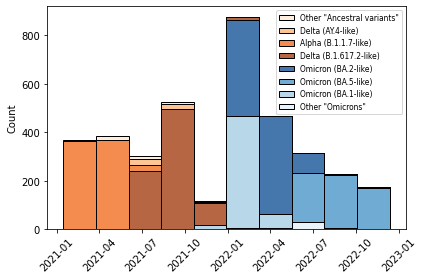

In [25]:
plot_df = meta_df.loc[STRAINS].copy()

plot_df.loc[
    (plot_df["group"] == "first") & \
    ~(plot_df["scorpio_call"].isin([
        "Delta (B.1.617.2-like)",
        "Alpha (B.1.1.7-like)",
        "Delta (AY.4-like)"
    ])), "scorpio_call"
] = 'Other "Ancestral variants"'

plot_df.loc[
    (plot_df["group"] == "second") & \
    ~(plot_df["scorpio_call"].isin([
        "Omicron (BA.2-like)",
        "Omicron (BA.5-like)",
        "Omicron (BA.1-like)"
    ])), "scorpio_call"
] = 'Other "Omicrons"'

plot_df.loc[
    plot_df["group"] == "first",
    "group"
] = "Early strains"

plot_df.loc[
    plot_df["group"] == "second",
    "group"
] = "Omicrons"

plot_df = plot_df.rename(columns={
    "scorpio_call": "Strain",
    "date": "Date",
    "group": "Group"
})

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    # bottom(np.linspace(0.1, 0.9, 11)),
    # top(np.linspace(0.1, 0.9, 8)),
    bottom(np.linspace(0.1, 0.9, 4)),
    top(np.linspace(0.1, 0.9, 4))
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.histplot(
    x="Date",
    hue="Strain",
    hue_order=[
        'Other "Ancestral variants"',
        "Delta (AY.4-like)",
        "Alpha (B.1.1.7-like)",
        "Delta (B.1.617.2-like)",
        "Omicron (BA.2-like)",
        "Omicron (BA.5-like)",
        "Omicron (BA.1-like)",
        'Other "Omicrons"'
    ],
    multiple="stack",
    data=plot_df,
    bins=10,
    palette=cmap.colors
)

handles = ax.get_legend().legendHandles
plt.legend(
    handles,
    [
        'Other "Ancestral variants"',
        "Delta (AY.4-like)",
        "Alpha (B.1.1.7-like)",
        "Delta (B.1.617.2-like)",
        "Omicron (BA.2-like)",
        "Omicron (BA.5-like)",
        "Omicron (BA.1-like)",
        'Other "Omicrons"'
    ],
    loc="upper right",
    prop={"size": 7.5}
)

plt.ylabel("Count")
plt.xlabel("")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("../../pictures/berlin-strains-300.tiff", dpi=300)
plt.savefig("../../pictures/berlin-strains-300.png", dpi=300)

# Binding regions

In [26]:
rdf = pd.read_csv(f"../../results/germany_ber/seed.csv", sep=";", index_col=0)
rdf.index = rdf.index.str.lstrip(">")
rdf["strain"] = rdf.index

# COAD analysis

## Higly expressed miRNAs

In [27]:
miRNA_df = pd.read_csv("../../miRNA/expressed_COAD.csv", sep=",")
miRNA_df.index = miRNA_df["MIMAT"]

TOTAL_EXPRESSION = miRNA_df["CPM"].sum()
MIMATS = miRNA_df["MIMAT"].to_list()

In [28]:
mrdf = rdf.loc[STRAINS][MIMATS]
mrdf["strain"] = mrdf.index

## Region count df

In [29]:
count_df = None

for protein in tqdm.tqdm(PROTEINS):
    df = mrdf.copy()    
    df["region"] = [protein] * len(df)
        
    if protein != "RNA":
        s, e = map(lambda x: int(x) - 1, ANNOTATION[protein].split("-"))
    else:
        s, e = None, None

    for mimat in MIMATS:
        df[mimat] = df[mimat].apply(lambda x: region_count(x, s, e))

    if count_df is None:
        count_df = df
    else:
        count_df = pd.concat([count_df, df], ignore_index=True)

count_df.loc[:, "count"] = 0
count_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    count_df["count"] += count_df[mimat] 
    count_df["weighted count"] += count_df[mimat] * expression

100%|██████████| 40/40 [00:00<00:00, 255.31it/s]


In [30]:
wcount_df = pd.read_csv("../../results/wuhan/seed.csv", sep=";", index_col=0)

for mimat in MIMATS:
    wcount_df[mimat] = wcount_df[mimat].apply(lambda x: region_count(x))
    
wcount_df.loc[:, "count"] = 0
wcount_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    wcount_df["count"] += wcount_df[mimat]
    wcount_df["weighted count"] += wcount_df[mimat] * expression

100%|██████████| 40/40 [00:00<00:00, 574.45it/s]


## Average count of binding regions

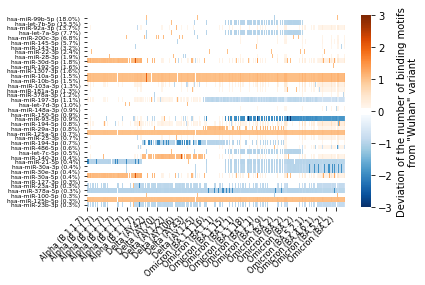

In [31]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()

plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]
plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "length"]], how="left")

for mimat in MIMATS:
    plot_df[mimat] = np.array(plot_df[mimat], dtype=np.float64) * \
        (29903 / np.array(plot_df["length"], dtype=np.float64)) - \
        np.array(wcount_df[mimat], dtype=np.float64)

plot_df["strain"] = plot_df["scorpio_call"].str.split("(").str[0] + "(" + \
    plot_df["lineage"] + ")"
plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]

plot_df = plot_df.transpose()

miRNA_df.index = miRNA_df["MIMAT"]
plot_df = plot_df.join(miRNA_df[["miRNA", "CPM"]], how="left").sort_values(by="CPM", ascending=False)
plot_df.index = plot_df["miRNA"]
plot_df = plot_df.drop(columns=["miRNA", "CPM"])

plot_df["index"] = plot_df.index
miRNA_df.index = miRNA_df["miRNA"]
plot_df["index"] = plot_df["index"].apply(lambda x: f"{x} ({miRNA_df.loc[x]['CPM'] / miRNA_df['CPM'].sum() * 100:.1f}%)")
miRNA_df.index = miRNA_df["MIMAT"]
plot_df.index = plot_df["index"]
plot_df = plot_df.drop(columns=["index"])

bottom = mpl.colormaps['Oranges']
top = mpl.colormaps['Blues_r']
colors = np.vstack((
    top(np.linspace(0, 1, 128)),
    [[0, 0, 0, 0]] * 10,
    bottom(np.linspace(0, 1, 128))
))
cmap = ListedColormap(colors, name='OrangeBlue')

sns.heatmap(
    plot_df,
    cmap=cmap,
    vmin=-3,
    vmax=3,
    # linewidths=1,
    # linecolor="white",
    cbar_kws={
        "ticks": [-3, -2, -1, 0, 1, 2, 3],
        # "label": "Отклонение количества регионов\nсвязывания от Wuhan варианта"
        "label": 'Deviation of the number of binding motifs\nfrom "Wuhan" variant'
    }
)

plt.yticks(
    [0.5 + i for i in range(len(plot_df))],
    labels=plot_df.index.to_list(),
    fontsize=6
)
plt.ylabel("")

plt.xticks(
    fontsize=8,
    rotation=45,
    ha="right"
)

plt.tight_layout()
plt.savefig("../../pictures/berlin-miRNA-covid-300.png", dpi=300)
plt.savefig("../../pictures/berlin-miRNA-covid-300.tiff", dpi=300)

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 81.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 79.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


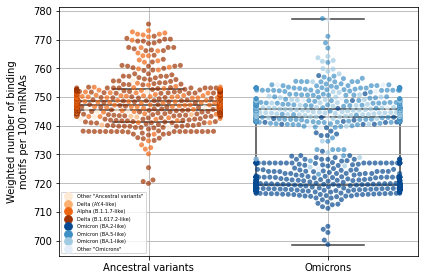

In [32]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[["weighted count"]]

plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "group", "length"]], how="left")

plot_df.loc[
    (plot_df["group"] == "first") & \
    ~(plot_df["scorpio_call"].isin([
        "Delta (B.1.617.2-like)",
        "Alpha (B.1.1.7-like)",
        "Delta (AY.4-like)"
    ])), "scorpio_call"
] = 'Other "Ancestral variants"'

plot_df.loc[
    (plot_df["group"] == "second") & \
    ~(plot_df["scorpio_call"].isin([
        "Omicron (BA.2-like)",
        "Omicron (BA.5-like)",
        "Omicron (BA.1-like)"
    ])), "scorpio_call"
] = 'Other "Omicrons"'

plot_df.loc[plot_df["group"] == "first", "group"] = "Ancestral variants"
plot_df.loc[plot_df["group"] == "second", "group"] = "Omicrons"
plot_df = plot_df.rename(columns={
    "scorpio_call": "Strain"
})

plot_df["weighted count"] = plot_df["weighted count"] * 29903 / plot_df["length"] * 100

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    # bottom(np.linspace(0.1, 0.9, 11)),
    # top(np.linspace(0.1, 0.9, 8)),
    bottom(np.linspace(0.1, 0.9, 4)),
    top(np.linspace(0.1, 0.9, 4))
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.swarmplot(
    y="weighted count",
    x="group",
    hue="Strain",
    hue_order=[
        'Other "Ancestral variants"',
        "Delta (AY.4-like)",
        "Alpha (B.1.1.7-like)",
        "Delta (B.1.617.2-like)",
        "Omicron (BA.2-like)",
        "Omicron (BA.5-like)",
        "Omicron (BA.1-like)",
        'Other "Omicrons"'
    ],
    alpha=0.7,
    data=plot_df,
    palette=cmap.colors,
)

ax = sns.boxplot(
    y="weighted count",
    x="group",
    data=plot_df,
    # palette=cmap.colors,
    boxprops={'facecolor': 'None'},
    whiskerprops={'linewidth': 0},
    showfliers=False,
    ax=ax
)

ax.set_xlabel("")
ax.set_ylabel("Weighted number of binding\nmotifs per 100 miRNAs")

# ax.set_yticks(
#     [6.8, 7.0, 7.2, 7.4, 7.6, 7.8],
#     [680, 700, 720, 740, 760, 780]
# )

# plt.xticks(
#     fontsize=8,
#     rotation=45,
#     ha="right"
# )

handles = ax.get_legend().legendHandles
handles = ax.get_legend().legendHandles
plt.legend(
    handles,
    [
        'Other "Ancestral variants"',
        "Delta (AY.4-like)",
        "Alpha (B.1.1.7-like)",
        "Delta (B.1.617.2-like)",
        "Omicron (BA.2-like)",
        "Omicron (BA.5-like)",
        "Omicron (BA.1-like)",
        'Other "Omicrons"'
    ],
    loc="lower left",
    prop={"size": 5}
)

plt.grid()
plt.tight_layout()
plt.savefig("../../pictures/berlin-covid-weighted-300.png", dpi=300)
plt.savefig("../../pictures/berlin-covid-weighted-300.tiff", dpi=300)

In [33]:
print(mannwhitneyu(
    plot_df.loc[plot_df["group"] == "Ancestral variants", "weighted count"].to_list(),
    plot_df.loc[plot_df["group"] == "Omicrons", "weighted count"].to_list(),
    # alternative="greater"
))

MannwhitneyuResult(statistic=2870367.0, pvalue=4.43966852054421e-254)


In [34]:
import numpy as np
from scipy.stats import spearmanr

In [35]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[["weighted count"]]

plot_df = plot_df.join(meta_df[[
    "scorpio_call", "lineage",
    "group", "length", "days"
]], how="left")


plot_df = plot_df.loc[
    plot_df["scorpio_call"] != "Omicron (BA.2-like)"
]

plot_df["weighted count"] = plot_df["weighted count"] * 29903 / plot_df["length"] * 100

spearmanr(
    plot_df["days"].to_list(),
    plot_df["weighted count"].to_list(),
    alternative="less"
)

SignificanceResult(statistic=-0.3421176982383663, pvalue=7.366029797653515e-80)

In [36]:
from datetime import timedelta, date

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


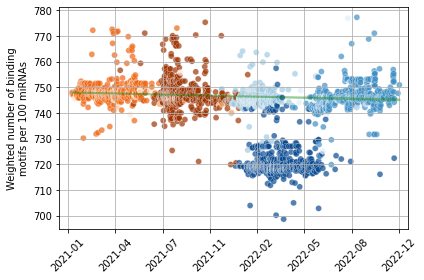

In [37]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[["weighted count"]]

plot_df = plot_df.join(meta_df[[
    "scorpio_call", "lineage",
    "group", "length", "days", "date"
]], how="left")

plot_df.loc[
    (plot_df["group"] == "first") & \
    ~(plot_df["scorpio_call"].isin([
        "Delta (B.1.617.2-like)",
        "Alpha (B.1.1.7-like)",
        "Delta (AY.4-like)"
    ])), "scorpio_call"
] = 'Other "Ancestral variants"'

plot_df.loc[
    (plot_df["group"] == "second") & \
    ~(plot_df["scorpio_call"].isin([
        "Omicron (BA.2-like)",
        "Omicron (BA.5-like)",
        "Omicron (BA.1-like)"
    ])), "scorpio_call"
] = 'Other "Omicrons"'

# plot_df = plot_df.loc[
#     plot_df["scorpio_call"] != "Omicron (BA.2-like)"
# ]

plot_df.loc[plot_df["group"] == "first", "group"] = "Ancestral variants"
plot_df.loc[plot_df["group"] == "second", "group"] = "Omicrons"
plot_df = plot_df.rename(columns={
    "scorpio_call": "Strain"
})

plot_df["weighted count"] = plot_df["weighted count"] * 29903 / plot_df["length"] * 100

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    # bottom(np.linspace(0.1, 0.9, 11)),
    # top(np.linspace(0.1, 0.9, 8)),
    bottom(np.linspace(0.1, 0.9, 4)),
    top(np.linspace(0.1, 0.9, 4))
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.scatterplot(
    x="days",
    y="weighted count",
    data=plot_df,
    hue="Strain",
    hue_order=[
        'Other "Ancestral variants"',
        "Delta (AY.4-like)",
        "Alpha (B.1.1.7-like)",
        "Delta (B.1.617.2-like)",
        "Omicron (BA.2-like)",
        "Omicron (BA.5-like)",
        "Omicron (BA.1-like)",
        'Other "Omicrons"'
    ],
    linewidth=0.3,
    alpha=0.7,
    palette=cmap.colors,
    legend=False
)

ax = sns.regplot(
    x=plot_df.loc[
        plot_df["Strain"] != "Omicron (BA.2-like)"
    ]["days"],
    y=plot_df.loc[
        plot_df["Strain"] != "Omicron (BA.2-like)"
    ]["weighted count"].astype(float),
    scatter=False,
    line_kws={
        'color': "green",
        'alpha': 0.3
    },
    order=1,
    ci=100,
    ax=ax
)

ax.set_xlim(left=350, right=1090)
ax.xaxis.set_ticks(list(range(370, 1170, 100)))
ax.xaxis.set_ticklabels(
    "-".join(str(date).split()[0].split("-")[:-1]) for date in [
        START + pd.DateOffset(days=d) for d in range(370, 1170, 100)
    ]
)

plt.xticks(rotation=45)
plt.xlabel("")
# ax.set_xlabel("Number of days since the pandemic start")
plt.ylabel("Weighted number of binding\nmotifs per 100 miRNAs")

plt.grid()
plt.tight_layout()
plt.savefig("../../pictures/berlin-covid-weighted-time-300.png", dpi=300)
plt.savefig("../../pictures/berlin-covid-weighted-time-300.tiff", dpi=300)

In [38]:
print(mannwhitneyu(
    plot_df.loc[
        (plot_df["group"] == "Ancestral variants") & \
        (plot_df["Strain"] != "Omicron (BA.2-like)"),
        "weighted count"
    ].to_list(),
    plot_df.loc[
        (plot_df["group"] == "Omicrons") & \
        (plot_df["Strain"] != "Omicron (BA.2-like)"),
        "weighted count"
    ].to_list(),
))

MannwhitneyuResult(statistic=1378968.0, pvalue=2.5699801764800735e-69)


## Seed region distribution

In [63]:
seed_df = rdf.copy()
seed_df = seed_df.loc[STRAINS][MIMATS]

seed_df = seed_df.join(meta_df[["lineage", "length", "days", "group", "scorpio_call"]], how="left")
seed_df = seed_df.loc[
    (seed_df["group"] == "second") # | \
#     (seed_df["scorpio_call"] != "Omicron (BA.2-like)")
]

seed_df.loc[
    (seed_df["scorpio_call"] == "Omicron (BA.2-like)"),
    "group"
] = "first"

seed_df.loc[
    (seed_df["scorpio_call"] != "Omicron (BA.2-like)"),
    "group"
] = "second"

seed_df = seed_df.drop(columns=["scorpio_call"])

In [64]:
first_group = seed_df.loc[seed_df["group"] == "first"]
second_group = seed_df.loc[seed_df["group"] == "second"]

In [65]:
def extract(seeds):
    seeds = seeds.lstrip("[").rstrip("]").split(", ")
    seeds = list(map(int, [s for s in seeds if s]))
    return seeds

result_df = pd.DataFrame(columns=["group", "seed", "miRNA"])
for name, group in zip(("first", "second"), (first_group, second_group)):
    coords = []
    for mimat in tqdm.tqdm(MIMATS):
        # expression = int(miRNA_df.loc[mimat]["CPM"] / TOTAL_EXPRESSION * 1000)
        # seeds = group[mimat].apply(lambda x: extract(x) * expression).to_list()
        weights = np.array(group[mimat].apply(lambda x: len(extract(x))))
        expression = np.ones(len(weights)) * int(miRNA_df.loc[mimat]["CPM"] / TOTAL_EXPRESSION * 1000)
        expression[weights <= 0] = 0
        weights[weights <= 0] = 1
        weights = np.array(expression / weights, dtype="int")
        seeds = group[mimat].apply(lambda x: extract(x)) * weights
        
        append = []
        for s in seeds:
            append += s
        
        append_df = pd.DataFrame(columns=result_df.columns)
        append_df["seed"] = append
        append_df.loc[:, "group"] = name 
        append_df.loc[:, "miRNA"] = mimat
        result_df = pd.concat([result_df, append_df], ignore_index=True)
        
result_df.head()

100%|██████████| 40/40 [00:04<00:00,  8.85it/s]


,group,seed,miRNA
0,first,12449,MIMAT0000062
1,first,19060,MIMAT0000062
2,first,12449,MIMAT0000062
3,first,19060,MIMAT0000062
4,first,12449,MIMAT0000062


### Ribosome hypothesis

In [471]:
ribo_df = pd.read_csv("../../external/covid-RPF.csv", sep=";")

In [472]:
ribo_df = ribo_df[["position", "RPF36"]].rename(columns={"RPF36": "RPF"})
positions = []
for i, row in tqdm.tqdm(ribo_df.iterrows(), total=len(ribo_df)):
    positions.extend([row["position"] - 1] * int(row["RPF"].split(",")[0]))
    
ribo_df = pd.DataFrame(positions, columns=["seed"])
ribo_df["group"] = "Ribosome"

100%|██████████| 29903/29903 [00:04<00:00, 6569.27it/s]


In [475]:
stat_df = result_df.copy()
stat_df = stat_df.drop(columns=["miRNA"])
stat_df = stat_df.loc[stat_df["group"] == "first"]
stat_df.loc[stat_df["group"] == "first", "group"] = "Ancestral variants"
# plot_df.loc[plot_df["group"] == "second", "group"] = "Omicrons"
stat_df = pd.concat([
    stat_df,
    ribo_df
], ignore_index=True)
stat_df = stat_df.sort_values(by="seed")

In [476]:
total_mir = len(stat_df.loc[stat_df["group"] == "Ancestral variants"])
total_rib = len(stat_df.loc[stat_df["group"] == "Ribosome"])

In [477]:
print(total_mir)
print(total_rib)

1358762
5124242


In [481]:
rst = np.zeros(shape=(29903, 3), dtype=np.int)
group = stat_df.groupby(["seed"])
for sd, df in tqdm.tqdm(group, total=29903):
    x = len(df.loc[df["group"] == "Ancestral variants"])
    y = len(df.loc[df["group"] == "Ribosome"])
    rst[sd] = [sd, x, y]

 88%|████████▊ | 26264/30000 [00:38<00:05, 682.61it/s]


In [482]:
print(len(rst))

29903


In [495]:
binnum = 1000
binsize = 29903 // binnum
bins = np.zeros(shape=(binnum, 2), dtype=np.float64)
for i in range(binnum):
    start = binsize * i
    end = binsize * (i + 1)
    
    if i == binnum:
        end = 29903
    bins[i] = rst[start:end, 1:].sum()

In [496]:
_with = []
_without = []
for i in tqdm.tqdm(range(len(bins))):
    x, y = bins[i]
    if x / total_mir > 0.01:
        _without.append(y)
    else:
        _with.append(y)

100%|██████████| 1000/1000 [00:00<00:00, 182893.82it/s]


In [497]:
print(len(_without), len(_with))

87 913


In [494]:
print(np.mean(_without), np.mean(_with))
mannwhitneyu(_without, _with)

93036.79104477612 7561.787878787879


MannwhitneyuResult(statistic=2211.0, pvalue=5.485123873174502e-16)

### Seed distribution

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


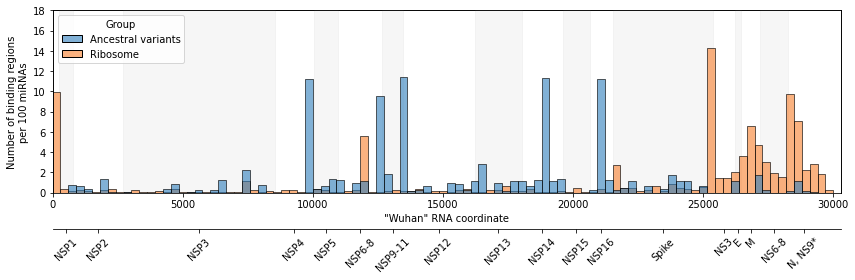

In [377]:
plot_df = result_df.copy()
plot_df = plot_df.drop(columns=["miRNA"])
plot_df = plot_df.loc[plot_df["group"] == "first"]
plot_df.loc[plot_df["group"] == "first", "group"] = "Ancestral variants"
# plot_df.loc[plot_df["group"] == "second", "group"] = "Omicrons"
plot_df = pd.concat([
    plot_df,
    ribo_df
], ignore_index=True)

plot_df = plot_df.rename(columns={
    "group": "Group"
})

fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylabel("Number of binding motifs\nper 100 miRNAs")
ax.set_xlabel('"Wuhan" RNA coordinate') 
ax.set_xlim(0, 30330)

annotation = {
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    # "NSP6": "10973-11842",
    # "NSP7": "11843-12091",
    # "NSP8": "12092-12685",
    "NSP6-8": "10973-12685",
    # "NSP9": "12686-13024",
    # "NSP10": "13025-13441",
    # "NSP11": "13442-13480",
    "NSP9-11": "12686-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    # "NS6": "27202-27387",
    # "NS7a": "27394-27759",
    # "NS7b": "27756-27887",
    # "NS8": "27894-28259",
    "NS6-8": "27202-28295",
    "N, NS9*": "28274-29533",
    # "NS9b": "28284-28577",
    # "NS9c": "28734-28955"
}

axsub = ax.twiny()
axsub.xaxis.set_ticks_position('bottom')
axsub.spines['bottom'].set_position(('outward', 36))

ticks = []
centers = []
proteins = []
for protein, region in annotation.items():
    start, end = map(int, region.split("-"))
    ticks.append(start - 1)
    ticks.append(end - 1)
    
    center = (start + end - 2) // 2
    centers.append(center)
    proteins.append(protein)

i = 0
while i < len(ticks):
    axsub.axvspan(ticks[i], ticks[i + 1], alpha=0.2, color="lightgrey")
    i += 4

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')
    
fg = sns.histplot(
    x="seed",
    hue="Group",
    hue_order=["Ancestral variants", "Ribosome"],
    data=plot_df,
    stat="probability",
    common_norm=False,
    bins=100,
    binrange=(0, 30330),
    palette=cmap.colors,
    alpha=0.6,
    ax=axsub
)

axsub.set_xlim(0, 30330)
    
axsub.set_xticks(
    centers,
    labels=proteins,
    rotation=45,
    ha="center"
)

axsub.set_xlabel("")

ax.set_ylim((0, 0.18))
ax.set_yticks(
    [i / 100 for i in range(0, 20, 2)],
    labels=[i for i in range(0, 20, 2)]
)

plt.tight_layout()

### Binding region distribution

In [ ]:
plot_df = result_df.copy()
plot_df.loc[plot_df["group"] == "first", "group"] = "Ancestral variants"
plot_df.loc[plot_df["group"] == "second", "group"] = "Omicrons"
plot_df = plot_df.rename(columns={
    "group": "Group"
})

fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylabel("Number of binding motifs\nper 100 miRNAs")
ax.set_xlabel('"Wuhan" RNA coordinate') 
ax.set_xlim(0, 30330)

annotation = {
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    # "NSP6": "10973-11842",
    # "NSP7": "11843-12091",
    # "NSP8": "12092-12685",
    "NSP6-8": "10973-12685",
    # "NSP9": "12686-13024",
    # "NSP10": "13025-13441",
    # "NSP11": "13442-13480",
    "NSP9-11": "12686-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    # "NS6": "27202-27387",
    # "NS7a": "27394-27759",
    # "NS7b": "27756-27887",
    # "NS8": "27894-28259",
    "NS6-8": "27202-28295",
    "N, NS9*": "28274-29533",
    # "NS9b": "28284-28577",
    # "NS9c": "28734-28955"
}

axsub = ax.twiny()
axsub.xaxis.set_ticks_position('bottom')
axsub.spines['bottom'].set_position(('outward', 36))

ticks = []
centers = []
proteins = []
for protein, region in annotation.items():
    start, end = map(int, region.split("-"))
    ticks.append(start - 1)
    ticks.append(end - 1)
    
    center = (start + end - 2) // 2
    centers.append(center)
    proteins.append(protein)

i = 0
while i < len(ticks):
    axsub.axvspan(ticks[i], ticks[i + 1], alpha=0.2, color="lightgrey")
    i += 4

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')
    
fg = sns.histplot(
    x="seed",
    hue="Group",
    hue_order=["Omicrons", "Ancestral variants"],
    data=plot_df,
    stat="probability",
    common_norm=False,
    bins=100,
    binrange=(0, 30330),
    palette=cmap.colors,
    alpha=0.6,
    ax=axsub
)

axsub.set_xlim(0, 30330)
    
axsub.set_xticks(
    centers,
    labels=proteins,
    rotation=45,
    ha="center"
)

axsub.set_xlabel("")

ax.set_ylim((0, 0.18))
ax.set_yticks(
    [i / 100 for i in range(0, 20, 2)],
    labels=[i for i in range(0, 20, 2)]
)

plt.tight_layout()
plt.savefig("../../pictures/berlin-seed-distribution-early-omicron2-300.png", dpi=300)
plt.savefig("../../pictures/berlin-seed-distribution-early-omicron2-300.tiff", dpi=300)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


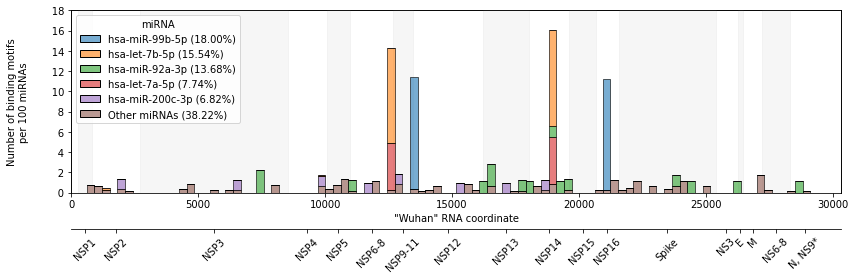

In [66]:
plot_df = result_df.loc[result_df["group"] == "first"]

mimats = miRNA_df.sort_values(
    by=["CPM"], ascending=False
).iloc[:5]["MIMAT"].to_list()

labels = []
plot_df.loc[~plot_df["miRNA"].isin(mimats), "miRNA"] = \
    f"Other miRNAs ({100 * (1 - miRNA_df.loc[mimats]['CPM'].sum() / TOTAL_EXPRESSION):.2f}%)"
for mimat in mimats:
    plot_df.loc[plot_df["miRNA"] == mimat, "miRNA"] = \
        f"{miRNA_df.loc[mimat]['miRNA']} ({miRNA_df.loc[mimat]['CPM'] / TOTAL_EXPRESSION * 100:.2f}%)"
    labels.append(f"{miRNA_df.loc[mimat]['miRNA']} ({miRNA_df.loc[mimat]['CPM'] / TOTAL_EXPRESSION * 100:.2f}%)")
labels.append(f"Other miRNAs ({100 * (1 - miRNA_df.loc[mimats]['CPM'].sum() / TOTAL_EXPRESSION):.2f}%)")
    
fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylabel("Number of binding motifs\nper 100 miRNAs")
ax.set_xlabel('"Wuhan" RNA coordinate')
ax.set_xlim(0, 30330)

annotation = {
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    # "NSP6": "10973-11842",
    # "NSP7": "11843-12091",
    # "NSP8": "12092-12685",
    "NSP6-8": "10973-12685",
    # "NSP9": "12686-13024",
    # "NSP10": "13025-13441",
    # "NSP11": "13442-13480",
    "NSP9-11": "12686-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    # "NS6": "27202-27387",
    # "NS7a": "27394-27759",
    # "NS7b": "27756-27887",
    # "NS8": "27894-28259",
    "NS6-8": "27202-28295",
    "N, NS9*": "28274-29533",
    # "NS9b": "28284-28577",
    # "NS9c": "28734-28955"
}

axsub = ax.twiny()
axsub.xaxis.set_ticks_position('bottom')
axsub.spines['bottom'].set_position(('outward', 36))

ticks = []
centers = []
proteins = []
for protein, region in annotation.items():
    start, end = map(int, region.split("-"))
    ticks.append(start - 1)
    ticks.append(end - 1)
    
    center = (start + end - 2) // 2
    centers.append(center)
    proteins.append(protein)

i = 0
while i < len(ticks):
    axsub.axvspan(ticks[i], ticks[i + 1], alpha=0.2, color="lightgrey")
    i += 4
    
sns.histplot(
    x="seed",
    hue="miRNA",
    hue_order=labels,
    data=plot_df,
    stat="probability",
    multiple="stack",
    bins=100,
    binrange=(0, 30330),
    alpha=0.6,
    ax=axsub
)

axsub.set_xlim(0, 30330)
    
axsub.set_xticks(
    centers,
    labels=proteins,
    rotation=45,
    ha="center"
)

axsub.set_xlabel("")

ax.set_ylim((0, 0.18))
ax.set_yticks(
    [i / 100 for i in range(0, 20, 2)],
    labels=["      " + str(i) for i in range(0, 20, 2)]
)

plt.tight_layout()
plt.savefig("../../pictures/berlin-seed-distribution-omicron2-2-300.png", dpi=300)
plt.savefig("../../pictures/berlin-seed-distribution-omicron2-2-300.tiff", dpi=300)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


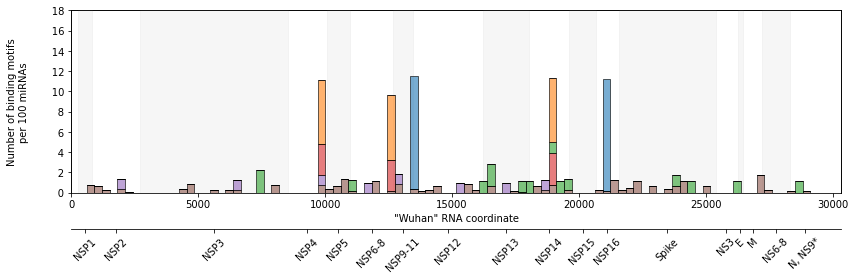

In [59]:
plot_df = result_df.loc[result_df["group"] == "second"]

mimats = miRNA_df.sort_values(
    by=["CPM"], ascending=False
).iloc[:5]["MIMAT"].to_list()

labels = []
plot_df.loc[~plot_df["miRNA"].isin(mimats), "miRNA"] = \
    f"Other miRNAs ({100 * (1 - miRNA_df.loc[mimats]['CPM'].sum() / TOTAL_EXPRESSION):.2f}%)"
for mimat in mimats:
    plot_df.loc[plot_df["miRNA"] == mimat, "miRNA"] = \
        f"{miRNA_df.loc[mimat]['miRNA']} ({miRNA_df.loc[mimat]['CPM'] / TOTAL_EXPRESSION * 100:.2f}%)"
    labels.append(f"{miRNA_df.loc[mimat]['miRNA']} ({miRNA_df.loc[mimat]['CPM'] / TOTAL_EXPRESSION * 100:.2f}%)")
labels.append(f"Other miRNAs ({100 * (1 - miRNA_df.loc[mimats]['CPM'].sum() / TOTAL_EXPRESSION):.2f}%)")
    
fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylabel("Number of binding motifs\nper 100 miRNAs")
ax.set_xlabel('"Wuhan" RNA coordinate')
ax.set_xlim(0, 30330)

annotation = {
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    # "NSP6": "10973-11842",
    # "NSP7": "11843-12091",
    # "NSP8": "12092-12685",
    "NSP6-8": "10973-12685",
    # "NSP9": "12686-13024",
    # "NSP10": "13025-13441",
    # "NSP11": "13442-13480",
    "NSP9-11": "12686-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    # "NS6": "27202-27387",
    # "NS7a": "27394-27759",
    # "NS7b": "27756-27887",
    # "NS8": "27894-28259",
    "NS6-8": "27202-28295",
    "N, NS9*": "28274-29533",
    # "NS9b": "28284-28577",
    # "NS9c": "28734-28955"
}

axsub = ax.twiny()
axsub.xaxis.set_ticks_position('bottom')
axsub.spines['bottom'].set_position(('outward', 36))

ticks = []
centers = []
proteins = []
for protein, region in annotation.items():
    start, end = map(int, region.split("-"))
    ticks.append(start - 1)
    ticks.append(end - 1)
    
    center = (start + end - 2) // 2
    centers.append(center)
    proteins.append(protein)

i = 0
while i < len(ticks):
    axsub.axvspan(ticks[i], ticks[i + 1], alpha=0.2, color="lightgrey")
    i += 4
    
fg = sns.histplot(
    x="seed",
    hue="miRNA",
    hue_order=labels,
    data=plot_df,
    stat="probability",
    multiple="stack",
    bins=100,
    alpha=0.6,
    binrange=(0, 30330),
    ax=axsub
)

fg.legend([], [], frameon=False)

axsub.set_xlim(0, 30330)
    
axsub.set_xticks(
    centers,
    labels=proteins,
    rotation=45,
    ha="center"
)

axsub.set_xlabel("")

ax.set_ylim((0, 0.18))
ax.set_yticks(
    [i / 100 for i in range(0, 20, 2)],
    labels=["      " + str(i) for i in range(0, 20, 2)]
)

plt.tight_layout()
plt.savefig("../../pictures/berlin-seed-distribution-omicron-300.png", dpi=300)
plt.savefig("../../pictures/berlin-seed-distribution-omicron-300.tiff", dpi=300)

In [67]:
mimats = miRNA_df.sort_values(
    by=["CPM"], ascending=False
).iloc[:5]["MIMAT"].to_list()

bin_len = 30330 // 100

first_mimat_dct = {
    mimat: np.zeros(100, dtype="int") for mimat in mimats
}
first_mimat_dct["other"] = np.zeros(100, dtype="int")

second_mimat_dct = {
    mimat: np.zeros(100, dtype="int") for mimat in mimats
}
second_mimat_dct["other"] = np.zeros(100, dtype="int")


for group, mimat_dct in zip(["first", "second"], [first_mimat_dct, second_mimat_dct]):
    df = result_df.loc[
        result_df["group"] == group
    ]
    
    for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
        bin_ind = row["seed"] // bin_len
        mimat = row["miRNA"]  

        if not (mimat in mimats):
            mimat = "other"

        mimat_dct[mimat][bin_ind] += 1

100%|██████████| 943980/943980 [02:10<00:00, 7254.00it/s]


In [68]:
first_total = 0
for mimat in tqdm.tqdm(first_mimat_dct):
    first_total += first_mimat_dct[mimat].sum()
    
second_total = 0
for mimat in tqdm.tqdm(second_mimat_dct):
    second_total += second_mimat_dct[mimat].sum()

100%|██████████| 6/6 [00:00<00:00, 27147.60it/s]


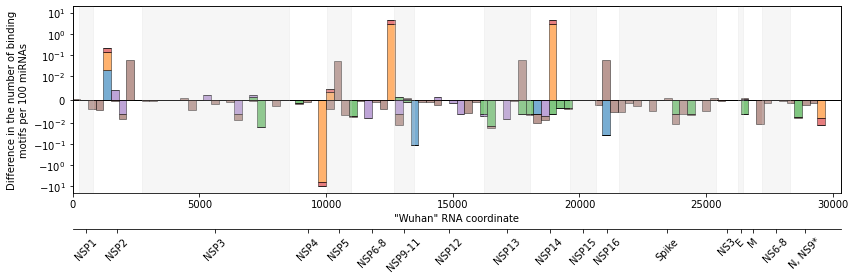

In [69]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylabel("Difference in the number of binding\nmotifs per 100 miRNAs")
ax.set_xlabel('"Wuhan" RNA coordinate')
ax.set_xlim(0, 30330)

annotation = {
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    # "NSP6": "10973-11842",
    # "NSP7": "11843-12091",
    # "NSP8": "12092-12685",
    "NSP6-8": "10973-12685",
    # "NSP9": "12686-13024",
    # "NSP10": "13025-13441",
    # "NSP11": "13442-13480",
    "NSP9-11": "12686-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    # "NS6": "27202-27387",
    # "NS7a": "27394-27759",
    # "NS7b": "27756-27887",
    # "NS8": "27894-28259",
    "NS6-8": "27202-28295",
    "N, NS9*": "28274-29533",
    # "NS9b": "28284-28577",
    # "NS9c": "28734-28955"
}

axsub = ax.twiny()
axsub.xaxis.set_ticks_position('bottom')
axsub.spines['bottom'].set_position(('outward', 36))

ticks = []
centers = []
proteins = []
for protein, region in annotation.items():
    start, end = map(int, region.split("-"))
    ticks.append(start - 1)
    ticks.append(end - 1)
    
    center = (start + end - 2) // 2
    centers.append(center)
    proteins.append(protein)

i = 0
while i < len(ticks):
    axsub.axvspan(ticks[i], ticks[i + 1], alpha=0.2, color="lightgrey")
    i += 4

diff_dct = {}
for mimat in mimats + ["other"]:
    diff_dct[mimat] = (
        np.array(first_mimat_dct[mimat]) / first_total * 100 - \
        np.array(second_mimat_dct[mimat]) / second_total * 100
    )

cp = sns.color_palette()
pos_bottom = np.zeros(100, dtype="float")
neg_bottom = np.zeros(100, dtype="float")

for mimat, color in zip(mimats + ["other"], cp):
    x = np.array(range(bin_len // 2, 30331, bin_len))
    pos_y = np.array(diff_dct[mimat])
    pos_y[pos_y < 0] = 0
    
    neg_y = np.array(diff_dct[mimat])
    neg_y[neg_y > 0] = 0
    
    ax.bar(
        x, pos_y,
        width=bin_len,
        bottom=pos_bottom,
        color=color,
        edgecolor="black",
        alpha=0.6,
        linewidth=0.7,
        label=mimat
    )
    pos_bottom += pos_y
     
    ax.bar(
        x, neg_y,
        width=bin_len,
        bottom=neg_bottom,
        color=color,
        edgecolor="black",
        alpha=0.6,
        linewidth=0.7
    )
    neg_bottom += neg_y

ax.set_ylim(-20, 20)
ax.set_yscale("symlog", linthresh=0.01)

axsub.set_xlim(0, 30330)
    
axsub.set_xticks(
    centers,
    labels=proteins,
    rotation=45,
    ha="center"
)

handles, labels = ax.get_legend_handles_labels()
labels = [
    f"{miRNA_df.loc[mimat]['miRNA']} ({miRNA_df.loc[mimat]['CPM'] / TOTAL_EXPRESSION * 100:.2f}%)" \
        for mimat in mimats
]
labels.append(f"Other miRNAs ({100 * (1 - miRNA_df.loc[mimats]['CPM'].sum() / TOTAL_EXPRESSION):.2f}%)")
# ax.legend(
#     title="miRNA",
#     handles=handles,
#     labels=labels,
#     loc="lower right",
#     prop={"size": 8}
# )

plt.tight_layout()
plt.savefig("../../pictures/berlin-seed-distribution-omicron2-2-omicron-diff-300.png", dpi=300)
plt.savefig("../../pictures/berlin-seed-distribution-omicron2-2-omicron-diff-300.tiff", dpi=300)

# Coding regions contribution

In [79]:
result_df = pd.DataFrame(columns=[
    "region", "length",
    "first weighted", "second weighted", "third weighted",
    "first count", "second count", "third count",
    "fsp-value", "ftp-value"
])

for protein in PROTEINS:
    if protein == "RNA":
        length = 29903
    else:
        length = list(map(int, ANNOTATION[protein].split("-")))
        length = length[1] - length[0] + 1
    
    df = count_df.loc[count_df["region"] == protein]
    df.index = df["strain"]
    df = df.join(meta_df[["group", "length", "scorpio_call"]], how="left")
    df = df.drop(columns=["strain"]).reset_index()
    
    first_group = df.loc[df["group"] == "first"][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    second_group = df.loc[
        (df["group"] == "second") & \
        (df["scorpio_call"] == "Omicron (BA.2-like)")
    ][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    
    third_group = df.loc[
        (df["group"] == "second") & \
        (df["scorpio_call"] != "Omicron (BA.2-like)")
    ][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    
    try:
        fsstat, fspv = mannwhitneyu(
            first_group["weighted count"],
            second_group["weighted count"]
        )
    except:
        fspv = 1
    
    try:
        ftstat, ftpv = mannwhitneyu(
            first_group["weighted count"],
            third_group["weighted count"]
        )
    except:
        ftpv = 1
        
    append_df = pd.DataFrame(
        columns=result_df.columns.to_list(),
        data=[[
            protein,
            length,
            first_group["weighted count"].mean(),
            second_group["weighted count"].mean(),
            third_group["weighted count"].mean(),
            first_group["count"].mean(),
            second_group["count"].mean(),
            third_group["count"].mean(),
            fspv,
            ftpv
        ]]
    )
    
    result_df = pd.concat([result_df, append_df], ignore_index=True)

result_df["fsfdr"] = np.array(result_df["fsp-value"]) * len(result_df) / rankdata(result_df["fsp-value"])
result_df["ftfdr"] = np.array(result_df["ftp-value"]) * len(result_df) / rankdata(result_df["ftp-value"])
result_df.loc[result_df["fsfdr"] > 1, "fsfdr"] = 1
result_df.loc[result_df["ftfdr"] > 1, "ftfdr"] = 1

In [80]:
result_df.loc[
    (result_df["fsfdr"] < 0.05) | \
    (result_df["ftfdr"] < 0.05)
].sort_values(by=["fsfdr", "ftfdr"], ascending=True)[:6]

,region,length,first weighted,second weighted,third weighted,first count,second count,third count,fsp-value,ftp-value,fsfdr,ftfdr
17,Spike,3822,0.906925,0.879747,0.881085,55.615021,52.994363,53.031436,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
29,RNA,29903,7.444063,7.169955,7.407960,386.901833,378.468997,382.823280,0.000000e+00,4.538155e-226,0.000000e+00,6.807233e-225
15,NSP15,1038,0.130679,0.123335,0.126850,13.982850,11.994363,12.919286,0.000000e+00,1.165773e-218,0.000000e+00,1.165773e-217
4,NSP4,1500,0.483055,0.249853,0.482121,18.992312,16.049605,18.977060,0.000000e+00,7.139670e-02,0.000000e+00,1.127316e-01
3,NSP3,5835,0.913042,0.905005,0.912764,65.896511,65.009019,65.926083,0.000000e+00,6.798651e-01,0.000000e+00,7.554056e-01
6,NSP6,870,0.338332,0.337317,0.339401,17.524542,16.990981,17.454545,1.534992e-142,1.201712e-12,7.674961e-142,6.008562e-12


In [81]:
result_df.loc[
    (result_df["fsfdr"] < 0.05) | \
    (result_df["ftfdr"] < 0.05)
].sort_values(by=["ftfdr", "fsfdr"], ascending=True)[:6]

,region,length,first weighted,second weighted,third weighted,first count,second count,third count,fsp-value,ftp-value,fsfdr,ftfdr
17,Spike,3822,0.906925,0.879747,0.881085,55.615021,52.994363,53.031436,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
29,RNA,29903,7.444063,7.169955,7.407960,386.901833,378.468997,382.823280,0.000000e+00,4.538155e-226,0.000000e+00,6.807233e-225
15,NSP15,1038,0.130679,0.123335,0.126850,13.982850,11.994363,12.919286,0.000000e+00,1.165773e-218,0.000000e+00,1.165773e-217
12,NSP12,2769,0.329812,0.327974,0.327768,23.018924,23.000000,22.930331,8.347780e-02,1.166475e-13,1.788810e-01,8.748566e-13
9,NSP9,339,0.172194,0.171468,0.171330,7.127735,6.992108,6.993203,9.345750e-11,2.186897e-13,3.115250e-10,1.312138e-12
6,NSP6,870,0.338332,0.337317,0.339401,17.524542,16.990981,17.454545,1.534992e-142,1.201712e-12,7.674961e-142,6.008562e-12


In [137]:
print_df = result_df.copy()
print_df["first weighted"] = print_df["first weighted"] * 29903 / print_df["length"]
print_df["second weighted"] = print_df["second weighted"] * 29903 / print_df["length"]
print_df["third weighted"] = print_df["third weighted"] * 29903 / print_df["length"]

print_df = print_df[[
    "region", "length",
    "first weighted",
    "second weighted", "fsfdr",
    "third weighted", "ftfdr"
]]

print_df["first weighted"] *= 100
print_df["second weighted"] *= 100
print_df["third weighted"] *= 100
print_df["second weighted"] = print_df["first weighted"] - print_df["second weighted"]
print_df["third weighted"] = print_df["first weighted"] - print_df["third weighted"]

print_df = print_df.loc[
    (print_df["fsfdr"] < 0.05) | \
    (print_df["ftfdr"] < 0.05)
].sort_values(by=["second weighted", "third weighted"], ascending=False)

for i, row in print_df.iterrows():
    for column in print_df.columns:
        if "fdr" in column:
            print(f"& {float(row[column]):.4f} ", end="")
        elif column not in ["region", "length"]:
            #print(f"& {float(row[column]):.2f} ", end="")
            print(f"& {int(row[column])} ", end="")
        elif column == "region":
            print(f"{row[column]} ", end="")
        else:
            print(f"& {row[column]} ", end="")
    print("\\\\")
    print("\\hline")

NSP4 & 1500 & 962 & 464 & 0.0000 & 1 & 0.1127 \\
\hline
RNA & 29903 & 744 & 27 & 0.0000 & 3 & 0.0000 \\
\hline
Spike & 3822 & 709 & 21 & 0.0000 & 20 & 0.0000 \\
\hline
NSP15 & 1038 & 376 & 21 & 0.0000 & 11 & 0.0000 \\
\hline
NSP9 & 339 & 1518 & 6 & 0.0000 & 7 & 0.0000 \\
\hline
NSP3 & 5835 & 467 & 4 & 0.0000 & 0 & 0.7554 \\
\hline
NSP6 & 870 & 1162 & 3 & 0.0000 & -3 & 0.0000 \\
\hline
NSP12 & 2769 & 356 & 1 & 0.1789 & 2 & 0.0000 \\
\hline
NSP14 & 1581 & 1781 & 1 & 0.8104 & 2 & 0.0129 \\
\hline
N & 1260 & 683 & 1 & 0.4540 & -1 & 0.0123 \\
\hline
NS7a & 366 & 223 & 0 & 0.5782 & 0 & 0.0458 \\
\hline
NSP13 & 1803 & 1659 & 0 & 0.0000 & 0 & 0.0000 \\
\hline
NS9b & 294 & 444 & 0 & 0.9704 & -4 & 0.0040 \\
\hline
E & 228 & 2338 & -2 & 0.1030 & -2 & 0.0486 \\
\hline
NSP2 & 1914 & 455 & -5 & 0.3511 & 3 & 0.0015 \\
\hline
NS9c & 222 & 2474 & -5 & 0.1000 & -7 & 0.0166 \\
\hline
NS3 & 828 & 243 & -5 & 0.0000 & 0 & 0.0002 \\
\hline
NSP1 & 540 & 498 & -7 & 0.0000 & -4 & 0.0001 \\
\hline
3P & 370 & 188

In [105]:
print_df = result_df.drop(columns=["first count", "second count", "p-value"])
print_df["first weighted"] *= 100
print_df["second weighted"] *= 100
print_df = print_df.loc[print_df["fdr"] < 0.05].sort_values(
    by=["fdr"]
)
print(print_df)

   region length  first weighted  second weighted            fdr
15  NSP15   1038       13.067929        12.533949   0.000000e+00
17  Spike   3822       90.692454        88.051023   0.000000e+00
29    RNA  30331      744.406291       730.567802   0.000000e+00
4    NSP4   1500       48.305543        38.230427  1.426694e-198
3    NSP3   5835       91.304234        90.942994   2.934366e-98
18    NS3    828        6.742484         6.829008   1.858597e-21
9    NSP9    339       17.219443        17.138935   2.192961e-20
6    NSP6    870       33.833226        33.850516   2.387790e-16
12  NSP12   2769       32.981168        32.785640   1.534167e-09
28     3P    798        2.338013         2.386886   1.208182e-08
19      E    228       17.831818        17.848223   1.088014e-02
27   NS9c    222       18.367628        18.418387   1.179914e-02
0      5P    265        0.009916         0.002703   3.269250e-02
26   NS9b    294        4.368368         4.394266   3.965955e-02


In [106]:
result_df.loc[result_df["region"] != "RNA"][["first weighted", "second weighted"]].sum()

first weighted     7.671380
second weighted    7.533805
dtype: float64

In [107]:
result_df.loc[result_df["region"] == "RNA"][["first count", "second count"]].sum()

first count     386.901833
second count    380.952035
dtype: float64

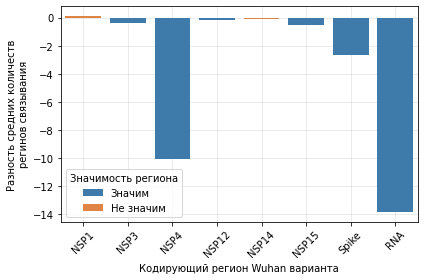

In [108]:
plot_df = result_df.copy()

plot_df["difference"] = (plot_df["second weighted"] - plot_df["first weighted"]) * 100
plot_df["fdr"] = np.array(plot_df["p-value"]) * len(plot_df) / rankdata(plot_df["p-value"])

plot_df["Значимость региона"] = "Не значим"
plot_df.loc[plot_df["fdr"] < 0.05, "Значимость региона"] = "Значим"

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.barplot(
    x="region",
    y="difference",
    hue="Значимость региона",
    hue_order=["Значим", "Не значим"],
    data=plot_df.loc[np.abs(plot_df["difference"]) > 0.1],
    palette=cmap.colors,
    dodge=False
)

plt.xlabel("Кодирующий регион Wuhan варианта")
plt.ylabel("Разность средних количеств\nрегинов связывания")
ax.set_axisbelow(True)
plt.grid(alpha=0.3)
plt.xticks(
    rotation=45,
    ha="center"
)
plt.tight_layout()
# plt.savefig("../../pictures/mRNA-contribution.png", dpi=500)